In [73]:
import os
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import detrend, butter, sosfiltfilt, iirnotch
from scipy.fft import fft
from scipy.stats import kurtosis, skew, entropy

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [74]:
BASE_DIR = os.getcwd()
DATASET_DIR = os.path.join(BASE_DIR, "AirCompressor")

In [75]:
def get_subfolders(directory):
    return [f.path for f in os.scandir(directory) if f.is_dir()]

def get_classname(subfolder):
    return os.path.basename(subfolder)

In [76]:
fs = 50000

notch_freqs = [50, 300]
Q = 30     

lp_cutoff = 12000   
lp_order = 6

In [77]:
def notch_filter(signal, f0):
    b, a = iirnotch(f0, Q, fs)
    return sosfiltfilt(np.array([[b[0], b[1], b[2], a[0], a[1], a[2]]]), signal)

def lowpass_filter(signal):
    sos = butter(lp_order, lp_cutoff, fs=fs, btype='low', output='sos')
    return sosfiltfilt(sos, signal)

def preprocess_signal(signal):
    signal = detrend(signal)
    for f in notch_freqs:
        signal = notch_filter(signal, f)
    signal = lowpass_filter(signal)
    return signal

In [78]:
def compute_fft(signal):
    fft_vals = np.abs(fft(signal))
    return fft_vals[:len(fft_vals)//2]

In [79]:
def FD_feature_extraction(fft_vals):
    return [
        np.mean(fft_vals),                     # 1 Mean
        np.std(fft_vals),                      # 2 Std
        np.max(fft_vals),                      # 3 Max
        np.min(fft_vals),                      # 4 Min
        np.sum(fft_vals),                      # 5 Energy
        np.sqrt(np.mean(fft_vals**2)),         # 6 RMS
        skew(fft_vals),                        # 7 Skewness
        kurtosis(fft_vals, fisher=False),      # 8 Kurtosis
        np.argmax(fft_vals),                   # 9 Peak frequency index
        np.var(fft_vals),                      # 10 Variance
        np.median(fft_vals),                   # 11 Median
        entropy(fft_vals + 1e-12),             # 12 Spectral entropy
        np.percentile(fft_vals, 75)            # 13 Spectral roll-off
    ]

In [ ]:
FDf_data = []
class_data = []

subfolders = get_subfolders(DATASET_DIR)

print("Detected classes:", [get_classname(s) for s in subfolders])

for subfolder in subfolders:
    class_name = get_classname(subfolder)

    for file in os.listdir(subfolder):
        if file.endswith(".dat"):
            file_path = os.path.join(subfolder, file)

            signal = np.loadtxt(file_path)

            signal = preprocess_signal(signal)

            fft_vals = compute_fft(signal)

            features = FD_feature_extraction(fft_vals)

            FDf_data.append(features)
            class_data.append(class_name)

X = np.array(FDf_data)

Detected classes: ['Bearing', 'Flywheel', 'Healthy', 'LIV', 'LOV', 'NRV', 'Piston', 'Riderbelt']


In [81]:
le = LabelEncoder()
y = le.fit_transform(class_data)

print("Classes:", le.classes_)
print("Total samples:", X.shape[0])

Classes: ['Bearing' 'Healthy' 'LIV' 'LOV']
Total samples: 900


In [82]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_scaled)

print("Original features:", X.shape[1])
print("Reduced features:", X_reduced.shape[1])

Original features: 13
Reduced features: 5


In [83]:
train_x, test_x, train_y, test_y = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42, shuffle=True
)

In [84]:
svc = SVC(kernel='rbf', probability=True, random_state=42)
svc.fit(train_x, train_y)

print("Training score:", svc.score(train_x, train_y))

cv_scores = cross_val_score(svc, train_x, train_y, cv=5)
print("CV mean:", cv_scores.mean())
print("CV std:", cv_scores.std())

Training score: 0.8847222222222222
CV mean: 0.8666666666666668
CV std: 0.017235657841653984


Test accuracy: 0.8833333333333333


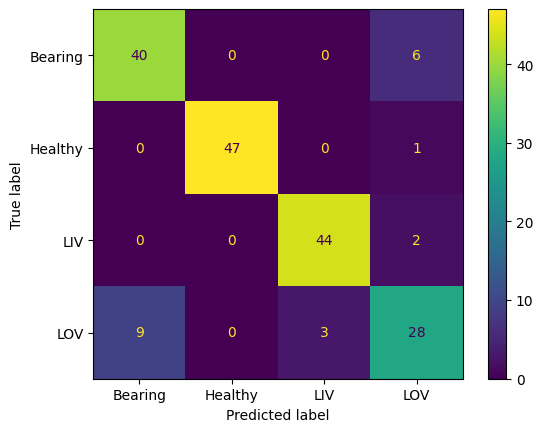

In [85]:
predicted_y = svc.predict(test_x)

print("Test accuracy:", accuracy_score(test_y, predicted_y))

cm = confusion_matrix(test_y, predicted_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)
disp.plot()
plt.show()